<a href="https://colab.research.google.com/github/LuigTi/CNN_NAS2/blob/main/CNN_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Dataset Class

In [2]:
class DigitsDataset(Dataset):
    '''
    Digit database from scikit-learn
    '''

    def __init__(self, mode = "train", transforms = None):
        digits = load_digits()

        #select the first 1000 datapoints as training set
        if mode == "train": 
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]

        #select 350 datapoints as training set
        elif mode == "val": 
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        
        #select the remaining datapoints as test set
        else: 
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]       
        #reshape datapoints from vector to matrix
        sample_x = sample_x.reshape(1, 8, 8) 
        sample_y = self.targets[idx]
        
        if torch.cuda.is_available(): #move on gpu if possible
          sample_x = torch.from_numpy(sample_x).to("cuda")
          sample_y = torch.from_numpy(np.array(sample_y)).to("cuda")

        return (sample_x, sample_y)

### CNN Class

In [3]:
class CNN(nn.Module):
    '''
    following the structure of:
      Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax

    ● Conv2d:
        ○ Number of filters: 8, 16, 32
        ○ kernel=(3,3), stride=1, padding=1 OR kernel=(5,5), stride=1, padding=2
    ● f(.):
        ○ ReLU OR sigmoid OR tanh OR softplus OR ELU
    ● Pooling:
        ○ 2x2 OR Identity
        ○ Average OR Maximum
    ● Linear 1:
        ○ Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    '''
    #rinomina tutto, 
    
    def __init__(self, 
                 conv_out = 8, # Number of filters: 8, 16, 32
                 kernel_params = 0, #0 OR 1
                      #0=> kernel=(3,3), stride=1, padding=1
                      #1=> kernel=(5,5), stride=1, padding=2
                 f1 = "ReLU", #possible activation functions:
                      #ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
                 f2 = "ReLU", #possible activation functions:
                      #ReLU OR Sigmoid OR Tanh OR Softplus OR ELU                 
                 pool_size = 2,  #2, identity
                 pooling = "avg", # avg, max
                 linear_out = 10 #10,20,30,40,50,60,70,80,90,100
                 ):
        super(CNN, self).__init__()


        #adjust the parameters depending on the input
        self.conv_out = conv_out 
        if kernel_params == 0: #kernel=(3,3), stride=1, padding=1
            self.kernel_size = 3 
            self.padding = 1 
        else:
            self.kernel_size = 5 
            self.padding = 2

        if pool_size == 2:
            self.pool_size = 2
        else:
            self.pool_size = 1

        self.linear_out = linear_out # Number of neurons

        #find the size of the tensor cefore entering the fully connected layer
        if True:
          #find the size after the convolutional layers
          size = 8 - self.kernel_size + 2 * self.padding + 1
          #find the size after the pooling layer
          size = (size - self.pool_size) / (self.pool_size) + 1
          #find the size after flattening
          size = int(size**2 * self.conv_out)


        #convolutional layers
        self.cnn =  nn.Conv2d(in_channels = 1, out_channels = conv_out, kernel_size = self.kernel_size, stride = 1, padding = self.padding)

        #activation function 1
        if f1 == "ReLU":    
            self.activation1 = nn.ReLU()
        elif f1 == "Sigmoid":
            self.activation1 = nn.Sigmoid()
        if f1 == "Tanh":    
            self.activation1 = nn.Tanh() 
        elif f1 == "Softplus":
            self.activation1 = nn.Softplus()
        elif f1 == "ELU":
            self.activation1 = nn.ELU()

        #pooling
        if pooling == "avg":
            self.pool = nn.AvgPool2d(kernel_size = pool_size)
        else:
            self.pool = nn.MaxPool2d(kernel_size = pool_size)
       
        #fully connected layer 1
        self.linear1 = nn.Linear(in_features = size, out_features = self.linear_out)

        #activation function 2
        if f2 == "ReLU":    
            self.activation2 = nn.ReLU()
        elif f2 == "Sigmoid":
            self.activation2 = nn.Sigmoid()
        if f2 == "Tanh":    
            self.activation2 = nn.Tanh() 
        elif f2 == "Softplus":
            self.activation2 = nn.Softplus()
        elif f2 == "ELU":
            self.activation2 = nn.ELU()

        #fully connected layer 1
        self.linear2 = nn.Linear(in_features = self.linear_out, out_features = 10)
        #softmax
        self.softmax = nn.LogSoftmax(dim=1)

        #loss funtion
        self.nll = nn.NLLLoss(reduction="none") 
    
    #classify method to find the prediccion of a datapoint
    def classify(self, x):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        #find prediction
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    #foward method for the foward pass
    def forward(self, x, y, reduction="avg"):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        
        #find the loss (it has as input the log_prob and targets)
        loss = self.nll(log_prob, y)
        #reduction for loss over a batch (either summ or mean)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    #find how many classifying mistakes were made
    def missclassified_datapoints(self, predictions, targets):
        #number of differences in the two vectors
        return torch.sum(predictions != targets) 

### Train and Evaluation Loops (one epoch) and Plot Function

In [4]:
def train_loop(dataloader, model, optimizer, verbose = True):

    #counters for train loss and missclassified and total datapoints
    loss_counter = 0
    missclass_counter = 0
    total_data_points = 0

    #get model on train mode
    model.train()

    #for datapoint and target in dataloader
    for (X, y) in dataloader:

        #get batch size
        batch_size = X.size(0)

        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #update total
        total_data_points += batch_size

    
    #find average loss and average classification error over the epoch 
    average_loss = float(loss_counter / total_data_points)
    average_ce = float(missclass_counter / total_data_points)
    if verbose == True:
      #print average loss and average classification error 
      print("\033[95mTRAINING\033[0m")
      print(f"        average train loss => {average_loss}")
      print(f"        average classification error => {average_ce}")
      print("")
      
    return average_loss, average_ce


In [5]:
def evaluation_loop(dataloader, model, mode = "validation", verbose = True):

    #counters for train loss and missclassified datapoints
    loss_counter = 0
    missclass_counter = 0

    #get model to eval mode
    model.eval()


    #to not save the gradients
    with torch.no_grad():
      #for datapoint and target in dataloader
      for (X, y) in dataloader:


        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints



    #find average loss and average classification error over the epoch 
    dataloader_size = len(dataloader.dataset)
    average_loss = float(loss_counter / dataloader_size)
    average_ce = float(missclass_counter / dataloader_size)
    if verbose == True:
      #print average loss and average classification error 
      if mode == "validation":
        print("\033[95mVALIDATION\033[0m")
      else:
        print("\033[92mTESTING\033[0m")

      print(f"        average {mode} loss => {average_loss}")
      print(f"        average {mode} classification error => {average_ce}")
      print("")

    return average_loss, average_ce


In [6]:
#function to plot
def plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_list = None, test_ce_list = None):
    #number of epoches
    n_epochs = len(train_loss_list)
    # Plotting train loss
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")

    # Plotting train classification error
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")

    # Plotting validation loss
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")

    # Plotting validation classification error
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")

    if test_loss_list != None and test_ce_list != None:
      # Plotting test loss
      plt.plot(range(1, n_epochs + 1), [test_loss_list] * n_epochs, label="Test Loss", linestyle="--")

      # Plotting test classification error
      plt.plot(range(1, n_epochs + 1), [test_ce_list] * n_epochs, label="Test Classification Error", linestyle="--")

    #labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Classification Error")
    plt.title("Training and Evaluation Results")
    plt.legend()

    #show the plot
    plt.show()

### Dataloaders and Full Training and Testing

In [7]:
#training, validation and test sets.
train_set = DigitsDataset(mode="train")
val_set = DigitsDataset(mode="val")
test_set = DigitsDataset(mode="test")

#data loaders.
training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [8]:
def full_cnn_loop(model, number_epoch = 20, testing = True, training_loader = None, val_loader = None, test_loader = None, verbose = True):


    for param in model.parameters():
      param.requires_grad = True
    opt = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)
    #initialize empty lists
    train_loss_list = []
    train_ce_list = []
    val_loss_list =[]
    val_ce_list =[]
    test_loss_list =[]
    test_ce_list =[]

    
    #progress bar if verbose
    if verbose:
      loop = tqdm(range(number_epoch))
    else:
      loop = range(number_epoch)
      
    #for number of epoches
    for i in loop:
      
      if verbose == True:
        print(f"\033[96mEPOCH NUMBER {i}\033[0m")

      #train loop
      train_loss, train_ce =  train_loop(dataloader = training_loader, model = model, optimizer = opt, verbose = verbose)
      train_loss_list.append(train_loss)
      train_ce_list.append(train_ce)

      #validation loop
      val_loss, val_ce = evaluation_loop(dataloader = val_loader, model = model, verbose = verbose)
      val_loss_list.append(val_loss)
      val_ce_list.append(val_ce)

    #testing loop (only if in testing mode)
    if testing == True:
      test_loss, test_ce = evaluation_loop(dataloader = test_loader, model = model, mode = "test", verbose = verbose)
      test_loss_list.append(test_loss)
      test_ce_list.append(test_ce)
    else:
      test_loss_list = None
      test_ce_list = None

    #plot graphs
    if verbose == True:
       plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_list, test_ce_list)

    if testing == True: #if in testing mode
      return min(test_loss_list), max(test_ce_list)
    else: #if in validation mode
      return  min(val_loss_list), max(val_ce_list)


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 2.344839096069336
        average classification error => 0.893000066280365

VALIDATION
        average validation loss => 2.289532423019409
        average validation classification error => 0.8257142901420593

EPOCH NUMBER 1
TRAINING
        average train loss => 2.2586939334869385
        average classification error => 0.8820000290870667

VALIDATION
        average validation loss => 2.2359044551849365
        average validation classification error => 0.8342856764793396

EPOCH NUMBER 2
TRAINING
        average train loss => 2.196608543395996
        average classification error => 0.8740000128746033

VALIDATION
        average validation loss => 2.161668539047241
        average validation classification error => 0.8171428442001343

EPOCH NUMBER 3
TRAINING
        average train loss => 2.111715078353882
        average classification error => 0.8050000667572021

VALIDATION
        average validation loss => 2.0727126598358154
 

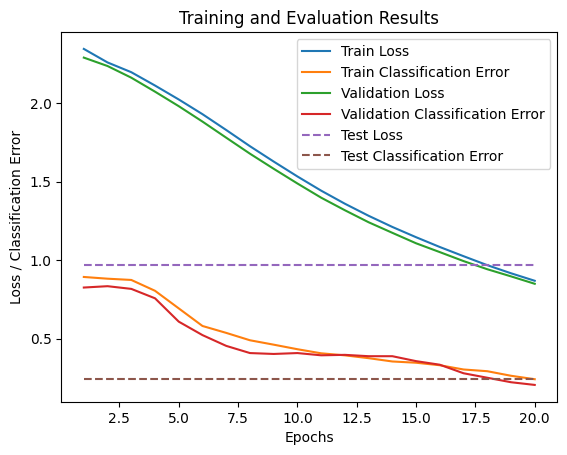

In [9]:
#example of a fool loop (no specified params for the architecture)
Random_model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Random_model.to(device)
_,_ = full_cnn_loop(model = Random_model, number_epoch = 20, testing = True, training_loader = training_loader, val_loader = val_loader, test_loader = test_loader)

### Neuroevolutionary Algorithm Class


GIVEN THAT THE FOLLOWING ARE THE POSSIBILITIES:

conv_out = 8, 16, 32

* kernel_params = 0, 1

          0=> kernel=(3,3), stride=1, padding=1
          
          1=> kernel=(5,5), stride=1, padding=2


* f1 = ReLU OR Sigmoid OR Tanh OR Softplus OR ELU     


* f2 = ReLU OR Sigmoid OR Tanh OR Softplus OR ELU          


* pool_size = 2, identity

* pooling =  avg, max

* linear_out = 10,20,30,40,50,60,70,80,90,100

THE FOLLOWING IS THE ENCODING:

**[conv_out, kernel_params, f1, f2, pool_size, pooling, linear_out]**

where their **RANGE** is:

  * conv_out => 0-1-2

  * kernel_params => 0-1
  
  * f1 => 0-1-2-3-4
  
  * f2 => 0-1-2-3-4
  
  * pool_size => 0-1
  
  * pooling => 0-1

  * linear_out => 0-1-2-3-4-5-6-7-8-9


In [10]:
class EA(object):
    def __init__(self, number_epoch = 10, pop_size = 10, p_parents = 0.8, nr_parents = 5, nr_candidate_child = 12):

        self.number_epoch = number_epoch #number epoch for each evaluation
        self.pop_size = pop_size #size of a population
        self.p_parents = p_parents #percentage of top indivuals from old generation taken as possible parents
        self.nr_parents = nr_parents #parents taken from each each generation
        self.nr_candidate_child = nr_candidate_child #candidate children after each recombination

        #max value of each entry (min is always 0)
        self.conv_out_max = 2
        self.kernel_params_max = 1
        self.f1_max = 4
        self.f2_max = 4
        self.pool_size_max = 1
        self.pooling_max = 2
        self.linear_out = 9


        #training, validation and test sets
        self.train_set = DigitsDataset(mode="train")
        self.val_set = DigitsDataset(mode="val")
        #data loaders
        self.training_loader = DataLoader(self.train_set, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(self.val_set, batch_size=64, shuffle=False)
       
      
    def parent_selection(self, x_old, f_old):

        #sort parents from best to worst fistness
        sorted_index = np.argsort(f_old)
        sorted_x_parents = np.array(x_old)[sorted_index]
        sorted_f_parents = np.array(f_old)[sorted_index]
        
        #p = hyperparameter
        p = float(self.p_parents)

        #the number of individuals in p percent
        range_p = int(self.pop_size * p)
        parents_list=[]
        parent_fitness =[]

        #for self.nr_parents times, sample with replacement (from the 100p best individuals from the old generaton)
        for i in range(self.nr_parents):
          #random index within the top range
          top_index = np.random.choice(range(range_p), size=1)
          #get individual at the randomly selected index from the top range
          random_top_ind = sorted_x_parents[top_index]
          random_top_ind_fitness = sorted_f_parents[top_index]
          #add the new parent to the list
          parents_list.append(random_top_ind)
          parent_fitness.append(random_top_ind_fitness)
        #turn list into numpy array
        array_parents = np.stack(parents_list).reshape((self.nr_parents, 7))    

        return array_parents, parent_fitness



    def recombination(self, x_parents, f_parents):
        candidate_children = []
        pop_size = len(x_parents)
        #since each loop 2 children are made => nr_candidate_child/2
        for i in range(int(self.nr_candidate_child/2)):

          #pick two random parents
          idx1, idx2 = np.random.choice(pop_size, size=2, replace=False)
          parent1 = x_parents[idx1]
          parent2 = x_parents[idx2]

          #pick a random number from 1 to 5
          random_number = np.random.randint(1, 6)

          #split the parents into twi halves
          half1_1 = x_parents[idx1][:random_number]
          half1_2 = x_parents[idx1][random_number:]
          half2_1 = x_parents[idx2][:random_number]
          half2_2 = x_parents[idx2][random_number:]

          #make the children as the cobination of two (un-paired) halves
          child1 = np.concatenate((half1_1, half2_2))
          child2 = np.concatenate((half2_1, half1_2))
          candidate_children.append(child1)
          candidate_children.append(child2)

        #turn list into numpy array of the right size 
        candidate_children = np.vstack(candidate_children)

        return candidate_children



    def mutation(self, x_children):    
        mutated_children = []
        for x_child in x_children:
            ex = [self.conv_out_max, self.kernel_params_max, self.f1_max, self.f2_max,self.pool_size_max, self.pooling_max,self.linear_out ]
            #pick a random number from 0 to 6
            random_number = np.random.randint(0, 7)
            
            #if the value of the entry picked is 0, add one
            if x_child[random_number] == 0:
              x_child[random_number] = x_child[random_number] + 1
            #if the value of the entry picked is the max, subtract 1
            elif x_child[random_number] == ex[random_number]:
              x_child[random_number] = x_child[random_number] - 1
            #if the value of the entry picked is not the max nor the min, either add or subtract 1
            else:
              random_choice = np.random.choice([-1, 1])
              x_child[random_number] = x_child[random_number] + random_choice
            mutated_children.append(x_child)

        mutated_children = np.vstack(mutated_children)
        return mutated_children 



    def survivor_selection(self, x_old, x_children, f_old, f_children):
        #combine parent and children populations
        x = np.vstack([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        
        #select the best individuals based on their fitness
        idx_sorted = np.argsort(f)
        x_sorted = x[idx_sorted]
        
        #keep the top individuals as the new population
        x_survivors = x_sorted[:self.pop_size]
        f_survivors = f[idx_sorted][:self.pop_size]
        return x_survivors, f_survivors



    def evaluate(self, x_pop):
        f = []

        #for each architecture in the population
        for x in x_pop:
          #convert genotype into usable paarameters
          y = self.nn_from_genotype(x)
          #initialize cnn and move it to CUDA if available
          cnn_to_evaluate =  CNN(conv_out = y[0], 
                                kernel_params = y[1], 
                                f1 = y[2],
                                f2 = y[3],               
                                pool_size = y[4],
                                pooling = y[5],
                                linear_out = y[6] )
          cnn_to_evaluate.to(device)

          _, validation_ce = full_cnn_loop(model = cnn_to_evaluate, number_epoch = self.number_epoch, testing = False, training_loader = self.training_loader, val_loader = self.val_loader, verbose = False)                 
          
          #count number of parameters in the CNN
          num_parameters = sum(p.numel() for p in cnn_to_evaluate.parameters())
          num_params_max = 206742
          #Objective = ClassError + λ * Np/Nmax
          fitness_x = validation_ce + 0.01*(num_parameters/num_params_max)
          f.append(fitness_x)

        return f

    @staticmethod
    def nn_from_genotype(genotype):
        '''
        transform genotype into parameters usable to create the CNN
        it follows the schema described above
        '''

        y = []
        #conv_out = 8, 16, 32
        if genotype[0] == 0:
          y.append(8)
        elif genotype[0] == 1:
          y.append(16)
        else:
          y.append(32)

        #kernel params= 0 or 1
        y.append(genotype[1])

        #f1= ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
        if genotype[2] == 0:
          y.append("ReLU")
        elif genotype[2] == 1:
          y.append("Sigmoid")
        elif genotype[2] == 2:
          y.append("Tanh")
        elif genotype[2] == 3:
          y.append("Softplus")
        else:
          y.append("ELU")

        #f1= ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
        if genotype[3] == 0:
          y.append("ReLU")
        elif genotype[3] == 1:
          y.append("Sigmoid")
        elif genotype[3] == 2:
          y.append("Tanh")
        elif genotype[3] == 3:
          y.append("Softplus")
        else:
          y.append("ELU")

        #pool_size = 2 or identity
        if genotype[3] == 0:
          y.append(2)
        else: 
          y.append(1)

        #pooling = avg, max
        if genotype[5] == 0:
          y.append("avg")
        else:
          y.append("max")
        
        #linear_out = 10,20,30,40,50,60,70,80,90,100
        a =  int(genotype[6])
        b = (a+1)*10
        y.append(b)
        
        #return the parameters 
        return y

    def step(self, x_old, f_old):

        x_parents, f_parents = self.parent_selection(x_old, f_old) # return a subset of the old population / parents and how fit they are

        x_children = self.recombination(x_parents, f_parents) # compute a set of INITIAL candidate solutions

        x_children = self.mutation(x_children)  # compute a set of FINAL candidate solutions, that are modified with perturbation

        f_children = self.evaluate(x_children) # compute the fitness of the FINAL candidate solutions

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children) # select the new population from the old population and the FINAL candidate solutions (or solely from the FINAL candidate solutions)<= commenting the code before implementing

        return x, f # return the new population and their fitness

### Running Loop ###

In [11]:
def create_random_idividual():

  ''' Given the following:
        conv_out_max = 2
        kernel_params_max = 1
        f1_max = 4
        f2_max = 4
        pool_size_max = 1
        pooling_max = 2
        linear_out = 9
  '''

  individual = []
  
  #define the range for each entry
  entry_ranges = [
      2,    # Range for entry 1
      1,    # Range for entry 2
      4,    # Range for entry 3
      4,    # Range for entry 4
      1,    # Range for entry 5
      2,    # Range for entry 6
      9     # Range for entry 7
  ]
    
  #generate a random integer within each range and append to the vector
  for entry_range in entry_ranges:
      entry = random.randint(0, entry_range)
      individual.append(entry)
    
  return individual

In [12]:
num_generations = 20
population_size = 15

ea = EA(number_epoch = 6, pop_size = population_size, p_parents = 0.3, nr_parents = 13, nr_candidate_child = 20)


# Init the population
x = [create_random_idividual() for _ in range(population_size)]
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f = np.array(f)
f_best = [f.min()]
best_individual = [x[np.argmin(f)]]

# Run the EA.
for i in tqdm(range(num_generations)):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
        best_individual.append(x[np.argmin(f)])
    else:
        f_best.append(f_best[-1])
        best_individual.append(best_individual[-1])

print("FINISHED!")

  0%|          | 0/20 [00:00<?, ?it/s]

Generation: 0, best fitness: 0.10
Generation: 2, best fitness: 0.06
Generation: 4, best fitness: 0.06
Generation: 6, best fitness: 0.06
Generation: 8, best fitness: 0.06
Generation: 10, best fitness: 0.05
Generation: 12, best fitness: 0.05
Generation: 14, best fitness: 0.05
Generation: 16, best fitness: 0.05
Generation: 18, best fitness: 0.05
FINISHED!


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.6284419298171997
        average classification error => 0.4130000174045563

VALIDATION
        average validation loss => 1.281618356704712
        average validation classification error => 0.2199999988079071

EPOCH NUMBER 1
TRAINING
        average train loss => 1.0853078365325928
        average classification error => 0.11300000548362732

VALIDATION
        average validation loss => 0.9984506368637085
        average validation classification error => 0.10285714268684387

EPOCH NUMBER 2
TRAINING
        average train loss => 0.884957492351532
        average classification error => 0.06100000441074371

VALIDATION
        average validation loss => 0.8503179550170898
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 3
TRAINING
        average train loss => 0.7518115639686584
        average classification error => 0.04800000041723251

VALIDATION
        average validation loss => 0.759286165

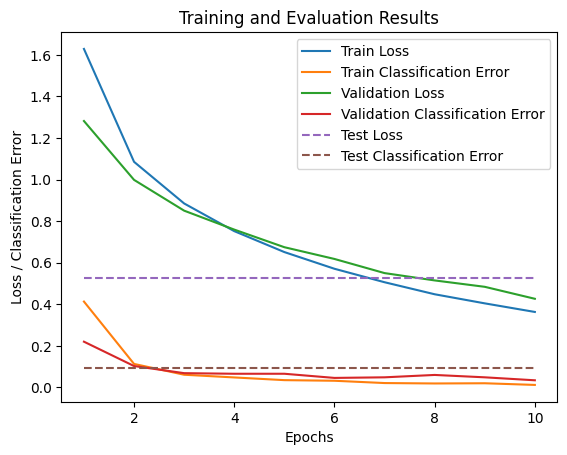

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.4425897598266602
        average classification error => 0.3230000138282776

VALIDATION
        average validation loss => 0.7797553539276123
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 1
TRAINING
        average train loss => 0.5344113707542419
        average classification error => 0.06300000101327896

VALIDATION
        average validation loss => 0.4222082495689392
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.30699217319488525
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.31169870495796204
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.21761472523212433
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.252

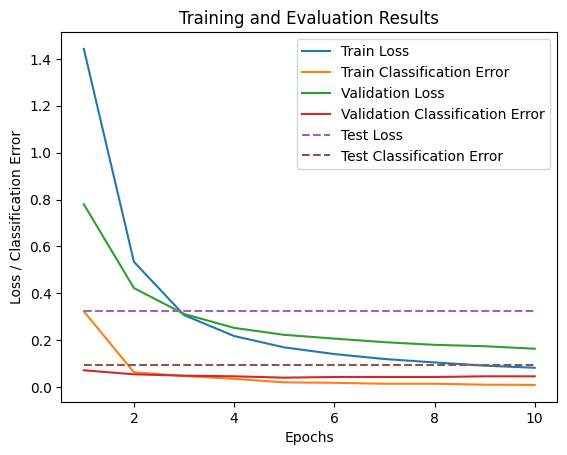

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.367836594581604
        average classification error => 0.367000013589859

VALIDATION
        average validation loss => 0.6276055574417114
        average validation classification error => 0.1257142871618271

EPOCH NUMBER 1
TRAINING
        average train loss => 0.36217615008354187
        average classification error => 0.08000000566244125

VALIDATION
        average validation loss => 0.3719868063926697
        average validation classification error => 0.10285714268684387

EPOCH NUMBER 2
TRAINING
        average train loss => 0.19777317345142365
        average classification error => 0.04800000041723251

VALIDATION
        average validation loss => 0.25722232460975647
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 3
TRAINING
        average train loss => 0.139155313372612
        average classification error => 0.036000002175569534

VALIDATION
        average validation loss => 0.2243951

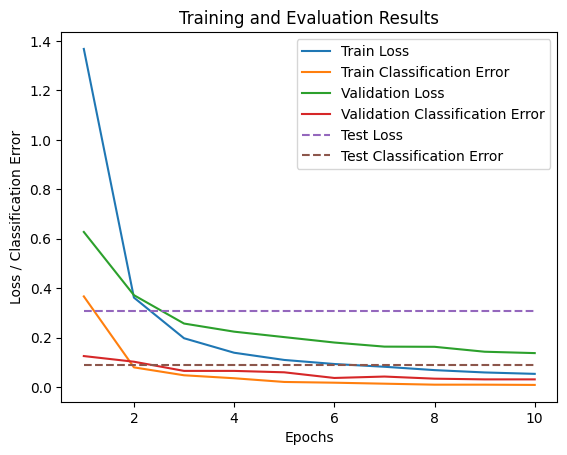

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.062604308128357
        average classification error => 0.28200000524520874

VALIDATION
        average validation loss => 0.4589754343032837
        average validation classification error => 0.10857142508029938

EPOCH NUMBER 1
TRAINING
        average train loss => 0.32052332162857056
        average classification error => 0.07700000703334808

VALIDATION
        average validation loss => 0.27113738656044006
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1973293423652649
        average classification error => 0.04800000041723251

VALIDATION
        average validation loss => 0.23978745937347412
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 3
TRAINING
        average train loss => 0.14820480346679688
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.18

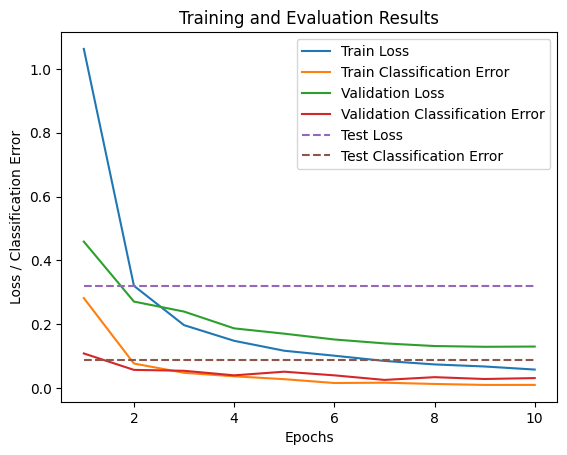

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0103925466537476
        average classification error => 0.2630000114440918

VALIDATION
        average validation loss => 0.36269888281822205
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 1
TRAINING
        average train loss => 0.21688058972358704
        average classification error => 0.049000002443790436

VALIDATION
        average validation loss => 0.20685173571109772
        average validation classification error => 0.037142857909202576

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13396625220775604
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.16740815341472626
        average validation classification error => 0.03142857179045677

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0922001451253891
        average classification error => 0.018000001087784767

VALIDATION
        average validation loss => 

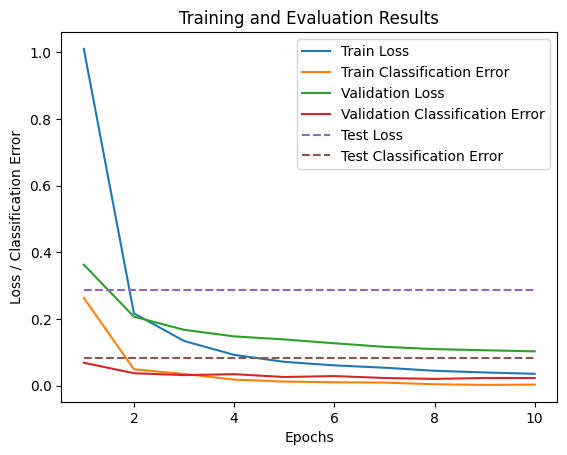

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0461008548736572
        average classification error => 0.2800000011920929

VALIDATION
        average validation loss => 0.40987661480903625
        average validation classification error => 0.09428571164608002

EPOCH NUMBER 1
TRAINING
        average train loss => 0.25464969873428345
        average classification error => 0.06400000303983688

VALIDATION
        average validation loss => 0.25967055559158325
        average validation classification error => 0.06857142597436905

EPOCH NUMBER 2
TRAINING
        average train loss => 0.14812014997005463
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.19026033580303192
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11151134967803955
        average classification error => 0.018000001087784767

VALIDATION
        average validation loss => 0

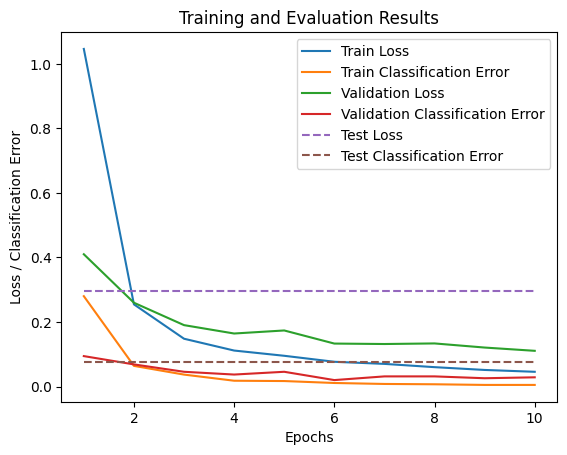

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1119384765625
        average classification error => 0.2600000202655792

VALIDATION
        average validation loss => 0.4354177415370941
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 1
TRAINING
        average train loss => 0.27947840094566345
        average classification error => 0.04700000211596489

VALIDATION
        average validation loss => 0.23503686487674713
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 2
TRAINING
        average train loss => 0.16186918318271637
        average classification error => 0.030000001192092896

VALIDATION
        average validation loss => 0.19199061393737793
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1202564686536789
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.167

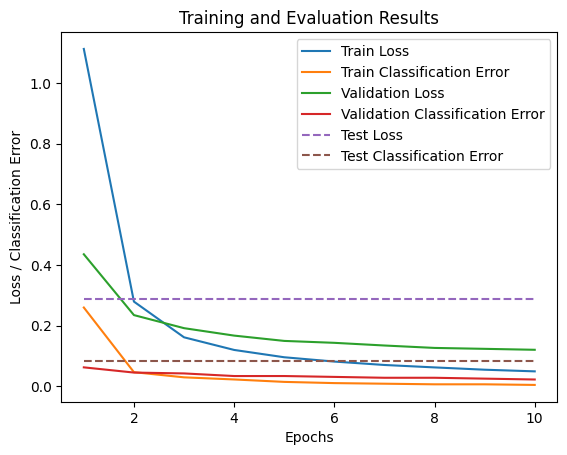

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0229343175888062
        average classification error => 0.25699999928474426

VALIDATION
        average validation loss => 0.35591068863868713
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2423979640007019
        average classification error => 0.0430000014603138

VALIDATION
        average validation loss => 0.22078515589237213
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 2
TRAINING
        average train loss => 0.14562378823757172
        average classification error => 0.027000000700354576

VALIDATION
        average validation loss => 0.17785723507404327
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11086375266313553
        average classification error => 0.018000001087784767

VALIDATION
        average validation loss => 

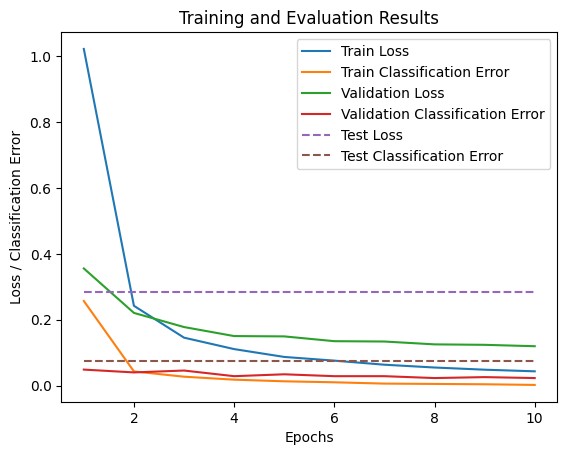

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0188813209533691
        average classification error => 0.2680000066757202

VALIDATION
        average validation loss => 0.42603799700737
        average validation classification error => 0.10000000149011612

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2706720530986786
        average classification error => 0.0650000050663948

VALIDATION
        average validation loss => 0.24364857375621796
        average validation classification error => 0.05999999865889549

EPOCH NUMBER 2
TRAINING
        average train loss => 0.16907228529453278
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.20229849219322205
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.11878235638141632
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.178

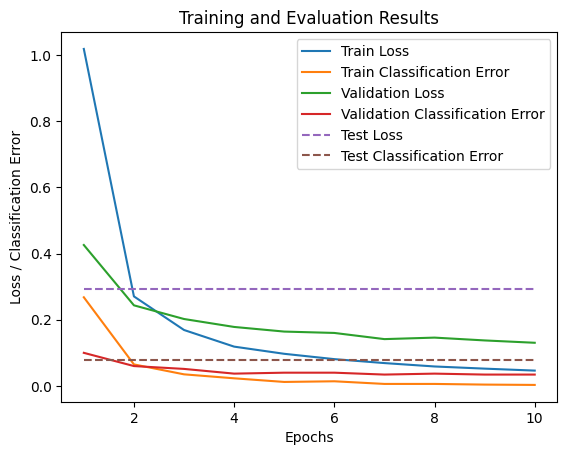

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.9303736686706543
        average classification error => 0.2370000183582306

VALIDATION
        average validation loss => 0.3331792652606964
        average validation classification error => 0.0771428570151329

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2168862521648407
        average classification error => 0.04800000041723251

VALIDATION
        average validation loss => 0.19981850683689117
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1322041004896164
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.13867567479610443
        average validation classification error => 0.03142857179045677

EPOCH NUMBER 3
TRAINING
        average train loss => 0.0994858592748642
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.1435

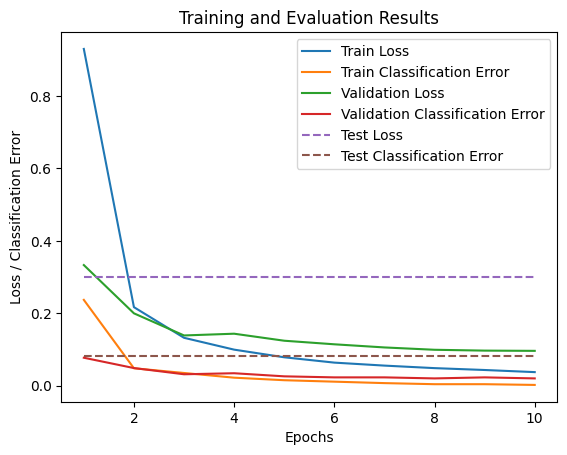

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.9515401721000671
        average classification error => 0.2540000081062317

VALIDATION
        average validation loss => 0.35573336482048035
        average validation classification error => 0.09142857044935226

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2218915820121765
        average classification error => 0.05300000309944153

VALIDATION
        average validation loss => 0.22136466205120087
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 2
TRAINING
        average train loss => 0.13030101358890533
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.18261542916297913
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09875606745481491
        average classification error => 0.026000000536441803

VALIDATION
        average validation loss => 0

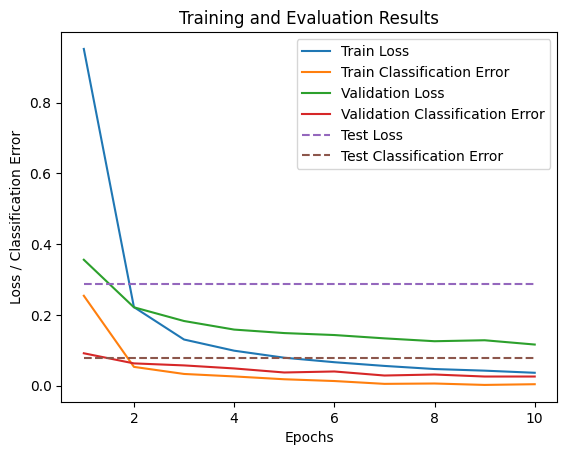

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.9392802119255066
        average classification error => 0.26100000739097595

VALIDATION
        average validation loss => 0.34331953525543213
        average validation classification error => 0.07999999821186066

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2050768882036209
        average classification error => 0.05000000074505806

VALIDATION
        average validation loss => 0.22945955395698547
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 2
TRAINING
        average train loss => 0.12102789431810379
        average classification error => 0.03100000135600567

VALIDATION
        average validation loss => 0.19501081109046936
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 3
TRAINING
        average train loss => 0.09025793522596359
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.

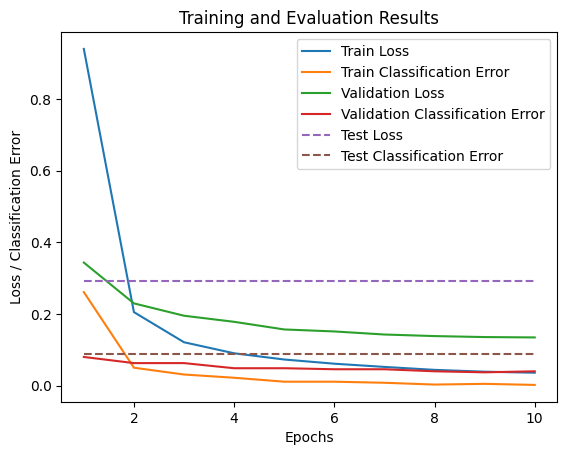

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0939563512802124
        average classification error => 0.3070000112056732

VALIDATION
        average validation loss => 0.4543955624103546
        average validation classification error => 0.0771428570151329

EPOCH NUMBER 1
TRAINING
        average train loss => 0.3012230694293976
        average classification error => 0.05300000309944153

VALIDATION
        average validation loss => 0.24371664226055145
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 2
TRAINING
        average train loss => 0.18325410783290863
        average classification error => 0.03200000151991844

VALIDATION
        average validation loss => 0.19270168244838715
        average validation classification error => 0.04285714402794838

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1363108605146408
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.178

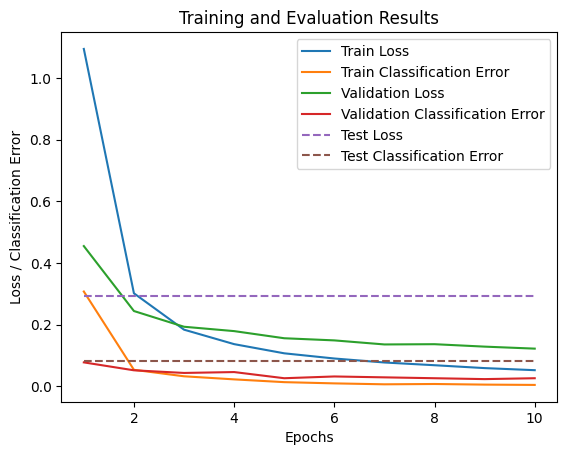

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.0374045372009277
        average classification error => 0.28200000524520874

VALIDATION
        average validation loss => 0.45701155066490173
        average validation classification error => 0.0714285671710968

EPOCH NUMBER 1
TRAINING
        average train loss => 0.2754072844982147
        average classification error => 0.052000001072883606

VALIDATION
        average validation loss => 0.2564251720905304
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.1613842397928238
        average classification error => 0.03200000151991844

VALIDATION
        average validation loss => 0.2167898565530777
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.12544292211532593
        average classification error => 0.023000001907348633

VALIDATION
        average validation loss => 0.18

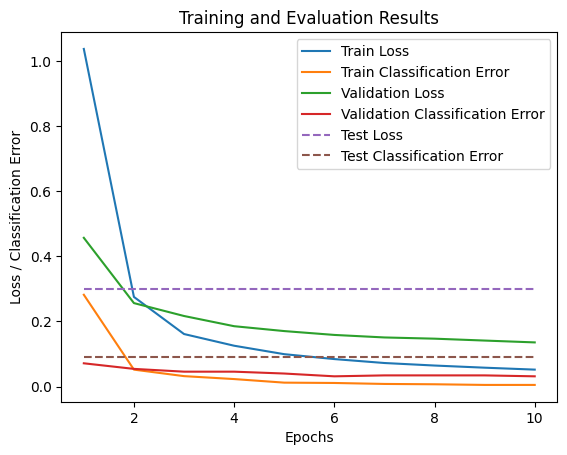

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2134729623794556
        average classification error => 0.27400001883506775

VALIDATION
        average validation loss => 0.48538127541542053
        average validation classification error => 0.08285713940858841

EPOCH NUMBER 1
TRAINING
        average train loss => 0.34012332558631897
        average classification error => 0.06300000101327896

VALIDATION
        average validation loss => 0.2608550488948822
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 2
TRAINING
        average train loss => 0.2042086124420166
        average classification error => 0.04000000283122063

VALIDATION
        average validation loss => 0.20424531400203705
        average validation classification error => 0.03142857179045677

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1520959883928299
        average classification error => 0.032999999821186066

VALIDATION
        average validation loss => 0.1

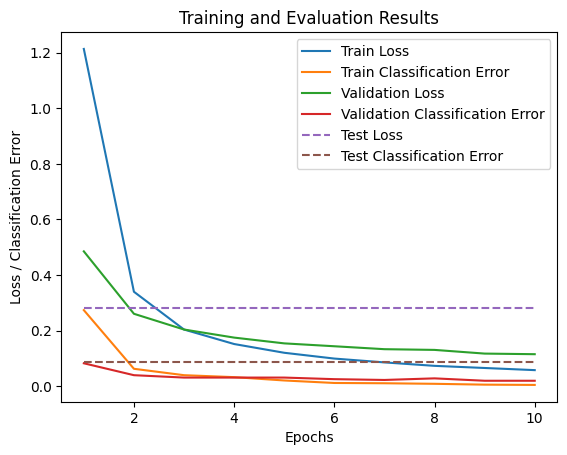

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2434661388397217
        average classification error => 0.3360000252723694

VALIDATION
        average validation loss => 0.5268884897232056
        average validation classification error => 0.07428571581840515

EPOCH NUMBER 1
TRAINING
        average train loss => 0.3636113405227661
        average classification error => 0.07400000095367432

VALIDATION
        average validation loss => 0.28923094272613525
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 2
TRAINING
        average train loss => 0.20103855431079865
        average classification error => 0.03200000151991844

VALIDATION
        average validation loss => 0.23274651169776917
        average validation classification error => 0.048571426421403885

EPOCH NUMBER 3
TRAINING
        average train loss => 0.14878804981708527
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss => 0.1

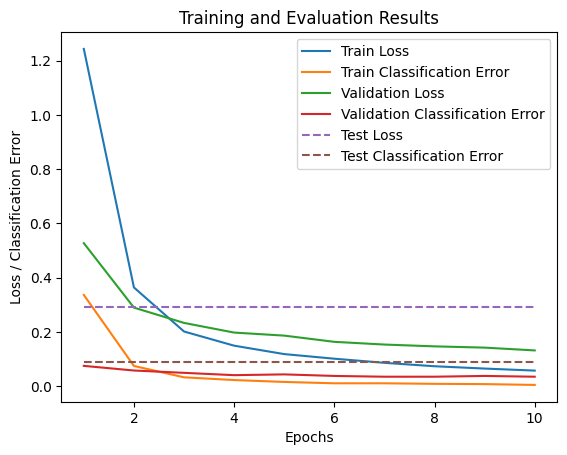

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.2032347917556763
        average classification error => 0.33800002932548523

VALIDATION
        average validation loss => 0.6474170088768005
        average validation classification error => 0.18285714089870453

EPOCH NUMBER 1
TRAINING
        average train loss => 0.3765547275543213
        average classification error => 0.08400000631809235

VALIDATION
        average validation loss => 0.3180626630783081
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 2
TRAINING
        average train loss => 0.21949706971645355
        average classification error => 0.049000002443790436

VALIDATION
        average validation loss => 0.25167354941368103
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.16157585382461548
        average classification error => 0.03500000014901161

VALIDATION
        average validation loss => 0.

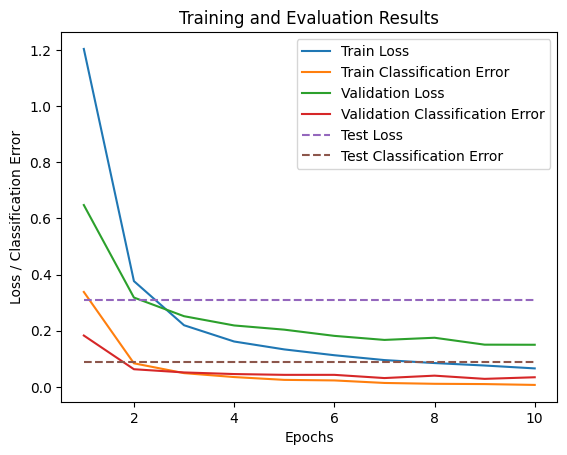

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.1896402835845947
        average classification error => 0.30900001525878906

VALIDATION
        average validation loss => 0.5187406539916992
        average validation classification error => 0.08571428805589676

EPOCH NUMBER 1
TRAINING
        average train loss => 0.3472732901573181
        average classification error => 0.0690000057220459

VALIDATION
        average validation loss => 0.285980224609375
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.20520219206809998
        average classification error => 0.04000000283122063

VALIDATION
        average validation loss => 0.23553597927093506
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 3
TRAINING
        average train loss => 0.14968156814575195
        average classification error => 0.02500000037252903

VALIDATION
        average validation loss => 0.2065

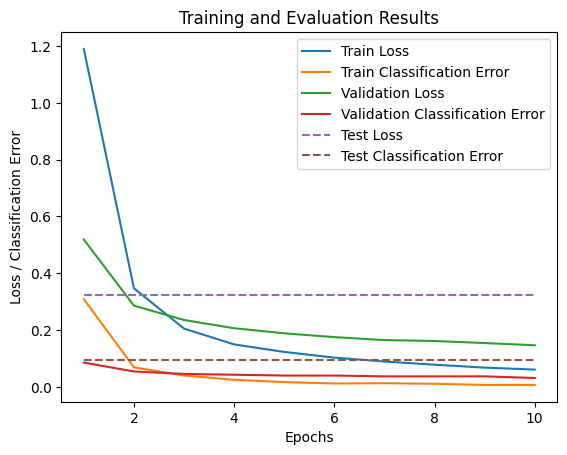

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.205241322517395
        average classification error => 0.2990000247955322

VALIDATION
        average validation loss => 0.5678821802139282
        average validation classification error => 0.08285713940858841

EPOCH NUMBER 1
TRAINING
        average train loss => 0.36341771483421326
        average classification error => 0.06599999964237213

VALIDATION
        average validation loss => 0.29978224635124207
        average validation classification error => 0.04571428522467613

EPOCH NUMBER 2
TRAINING
        average train loss => 0.2118074744939804
        average classification error => 0.04000000283122063

VALIDATION
        average validation loss => 0.2228136956691742
        average validation classification error => 0.03999999910593033

EPOCH NUMBER 3
TRAINING
        average train loss => 0.15025539696216583
        average classification error => 0.026000000536441803

VALIDATION
        average validation loss => 0.192

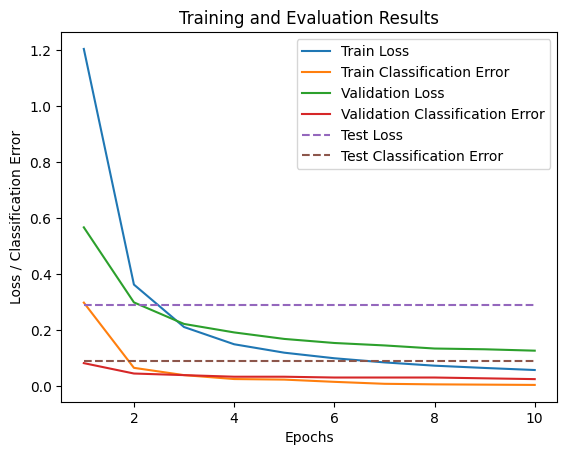

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.3129688501358032
        average classification error => 0.33100003004074097

VALIDATION
        average validation loss => 0.614123523235321
        average validation classification error => 0.07428571581840515

EPOCH NUMBER 1
TRAINING
        average train loss => 0.41802459955215454
        average classification error => 0.07700000703334808

VALIDATION
        average validation loss => 0.38284945487976074
        average validation classification error => 0.0657142847776413

EPOCH NUMBER 2
TRAINING
        average train loss => 0.24991612136363983
        average classification error => 0.055000003427267075

VALIDATION
        average validation loss => 0.25049570202827454
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.18251916766166687
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.

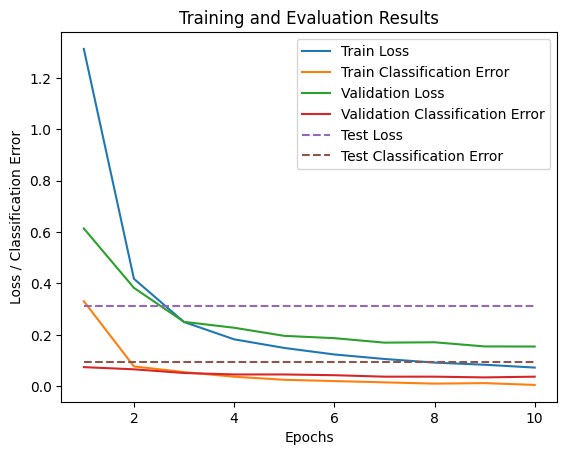

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 1.16087007522583
        average classification error => 0.31800001859664917

VALIDATION
        average validation loss => 0.45223283767700195
        average validation classification error => 0.06285714358091354

EPOCH NUMBER 1
TRAINING
        average train loss => 0.31050124764442444
        average classification error => 0.06000000238418579

VALIDATION
        average validation loss => 0.2710980772972107
        average validation classification error => 0.05714285746216774

EPOCH NUMBER 2
TRAINING
        average train loss => 0.18989551067352295
        average classification error => 0.03700000047683716

VALIDATION
        average validation loss => 0.22072814404964447
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.1406985968351364
        average classification error => 0.024000000208616257

VALIDATION
        average validation loss => 0.1

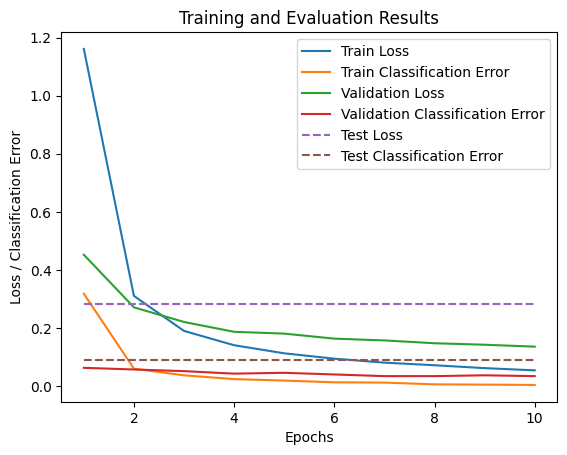

List of best individuals of each generation:
[[1, 1, 0, 2, 1, 1, 3], array([1, 1, 2, 4, 0, 1, 4]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([1, 0, 4, 4, 0, 0, 5]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([2, 0, 2, 4, 0, 0, 7]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([1, 0, 4, 4, 0, 0, 8]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5]), array([2, 0, 2, 4, 1, 1, 5])]


In [13]:
#testing the best models
test_loss_for_each_generation = []
test_ce_for_each_generation = []
for model in best_individual:
  params = EA.nn_from_genotype(model)

  best_model = CNN(conv_out = params[0],
                   kernel_params = params[1], 
                   f1 = params[2],
                   f2 = params[3],                 
                   pool_size = params[4],
                   pooling = params[5],
                   linear_out = params[6])
  best_model.to(device)
  #properly train and test the model
  #dataloaders are initialized before
  test_loss, test_ce = full_cnn_loop(model =best_model, number_epoch = 10, testing = True, 
                                               training_loader = training_loader, 
                                               val_loader = val_loader, 
                                               test_loader = test_loader, 
                                               verbose = True)
  
  test_loss_for_each_generation.append(test_loss)
  test_ce_for_each_generation.append(test_ce)

  print("List of best individuals of each generation:")
  print(best_individual)



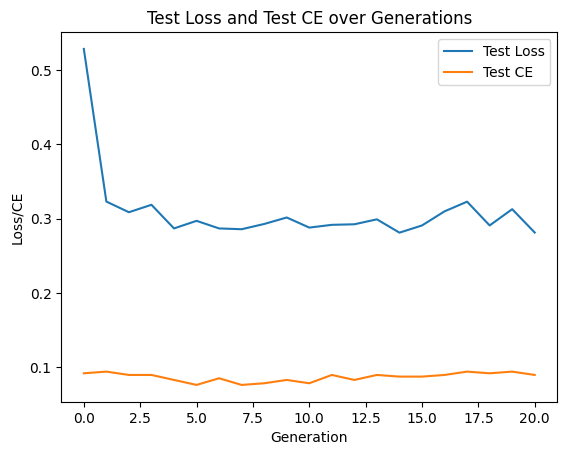

In [14]:
#plotting test loss and test ce over generations
plt.plot(test_loss_for_each_generation, label='Test Loss')
plt.plot(test_ce_for_each_generation, label='Test CE')

#adding labels and title
plt.xlabel('Generation')
plt.ylabel('Loss/CE')
plt.title('Test Loss and Test CE over Generations')
plt.legend()

#display
plt.show()